In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask.dataframe as dd
import dask.array as da
import itertools

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.addHandler(logging.FileHandler('Logs/pairsim_{0}.log'.format(datetime.datetime.now().\
                                                            strftime("%Y-%m-%d"), 'a')))
print = logging.info
print('good day to you madam fiona')
print('started')
print(datetime.datetime.now())

INFO:root:good day to you madam fiona
INFO:root:started
INFO:root:2018-07-28 01:25:47.677058


## 1. Similarity

See helpful code here: https://stackoverflow.com/questions/3992735/python-generator-that-groups-another-iterable-into-groups-of-n

In [4]:
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])


In [5]:
import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]
files = ["DataStore/2018-07-P2/Nano/nano_samp_0723.pkl"]
out_files = ["DataStore/2018-07-P2/Nano/nano_sim_0723.pkl"]

for i,f in enumerate(files):
    print("Loading sample data")
    print(f)
    # 1. Load data
    l2 = pd.read_pickle(f)
    l2 = l2.drop_duplicates()
    print(len(l2))
    for dm in dms:
        print("Loading matrix and dict")
        print(datetime.datetime.now())

        pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
        pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
        # Store as dask array
        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        pm = dd.read_parquet("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm)).values.compute()
        pm = da.from_array(pm, chunks=(10000,ncols))

        print("Getting row values")
        print(datetime.datetime.now())
        #----------#
        # 2. Get pat vecs & pat similarity
        print(len(l2))
        # Remove missing values
        l3 = l2[["tp", "op"]].loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys())]

        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        print(len(l3))

        print("Getting chunks")
        print(datetime.datetime.now())
        # Split into chunks
        n_rows = 3000
        n_chunks = int(np.round(len(l3)/n_rows))
        tp_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["tp"].tolist()]].compute())
        op_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["op"].tolist()]].compute())
        chunks = itertools.zip_longest(tp_chunks, op_chunks)

        print("Getting patent pair similarity")
        print("cosine")
        print(datetime.datetime.now())
        # Cosine

        cos_dis = np.empty(len(l3))

        for r, c in enumerate(chunks):
            cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))

        l3["sim_{0}".format(dm)] = 1-cos_dis
        del(cos_dis)

        l2 = l2.merge(l3[["tp", "op", "sim_{0}".format(dm)]], how = "left", on = ["tp", "op"])
        print(len(l2))           
        print("Finished {0}".format(dm))
        print(datetime.datetime.now())
    l2 = l2.drop_duplicates()
    print(len(l2))
    l2.to_pickle(out_files[i])
    

INFO:root:Loading sample data
INFO:root:DataStore/2018-07-P2/Nano/nano_samp_0723.pkl
INFO:root:1106731
INFO:root:Loading matrix and dict
INFO:root:2018-07-28 01:26:53.993902
INFO:root:Getting row values
INFO:root:2018-07-28 01:27:04.486658
INFO:root:1106731
INFO:root:1106731
INFO:root:Getting chunks
INFO:root:2018-07-28 01:27:05.273460
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-28 01:27:07.717840
INFO:root:1107651
INFO:root:Finished ldavecs
INFO:root:2018-07-28 01:28:45.685673
INFO:root:Loading matrix and dict
INFO:root:2018-07-28 01:28:45.686474
INFO:root:Getting row values
INFO:root:2018-07-28 01:29:11.935375
INFO:root:1107651
INFO:root:1107651
INFO:root:Getting chunks
INFO:root:2018-07-28 01:29:12.815017
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-28 01:29:17.129582
INFO:root:1113171
INFO:root:Finished docvecs
INFO:root:2018-07-28 01:31:45.947833
INFO:root:1106731


In [11]:
op_s_col = "op_is_nano"
tp_s_col = "tp_is_nano"

tr_out = ["DataStore/2018-07-P2/Nano/nano_transformed_0723.pkl"]
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Nano/nano_pats.pkl")
ts = pd.read_pickle(out_files[0])    
ts = ts.merge(pdf.add_prefix("tp_"), how = "left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
print(len(ts))
ts = ts.merge(pdf.add_prefix("op_"), how = "left", left_on="op", right_on="op_patent").drop("op_patent",1)
print(len(ts))
del(pdf)
# Add year diff
ts["year_diff"] = ts["op_appyear"] - ts["tp_appyear"]
# Add if software
ts[tp_s_col] = ts[op_s_col] = False
ts.loc[ts["tp"].isin(sw_pats.tolist()), tp_s_col] = True
ts.loc[ts["op"].isin(sw_pats.tolist()), op_s_col] = True

for c in ["naics_name", "primclass", "inv_msa"]:
    ts["{0}_match".format(c)] = (ts["tp_{0}".format(c)] == ts["op_{0}".format(c)])

# eps = 0.01
# dv_min = 0.7
# def scale_docvecs(x):
#     scaled = ((x+dv_min)/(1+dv_min))*(1-eps)+eps
#     return scaled
# def scale_ldavecs(x):
#     scaled = x*(1-eps)+eps
#     return scaled
# ts["sim_ldavecs"] = ts["sim_ldavecs"].apply(scale_ldavecs)
# ts["sim_docvecs"] = ts["sim_docvecs"].apply(scale_docvecs)

ts.to_pickle(tr_out[0])



INFO:root:1106731
INFO:root:1106731


____

## 2. Software patent similarity

1. Average similarity for all target patents for (i) in MSA and (ii) in Field
2. Plot Not Samp target patents similarity to the "in field" sample
3. Plot Samp target patents similarity to the "in field" sample
4. For each year, Get difference of 2 & 3; also p-value of significance of difference
5. Plot Not Samp target patents similarity to the "in MSA" sample
6. Plot Samp target patents similarity to the "in MSA" sample
7. For each target, get difference between "in MSA" to "in field" and plot. Also p-value of significance of difference

In [14]:
tr_out = ["DataStore/2018-07-P2/Nano/nano_transformed_0723.pkl"]
op_s_col = "op_is_nano"
tp_s_col = "tp_is_nano"
ts = pd.read_pickle(tr_out[0])
yr_min = 1994
yr_max = 2005
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1))]
# Remove where other patent is also software
print(len(ts))
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1)) & (ts[op_s_col] == False)]
print(len(ts))

919175
905227


In [25]:
# Average by target patent similarity
k = "tp_is_nano"
yr = "tp_appyear"

res = pd.DataFrame()
cols = ["tp", k, "samp", "inv_msa_match", "tp_appyear", "tp_primclass",\
        "sim_ldavecs", "sim_docvecs", "year_diff"]
# Split dataframe into relevant sample groups: (samp, in field), (samp, in msa), 
# (nonsamp, in field), (nonsamp, in msa)
tp_sim = ts[cols].groupby(["tp", "samp"]).mean().reset_index().dropna(how="any")
tp_samp_field = tp_sim.loc[(tp_sim[k] == True) & (tp_sim["samp"] == "In Field")]
tp_nonsamp_field = tp_sim.loc[(tp_sim[k] == False) &(tp_sim["samp"] == "In Field")]

# Get mean similarity of each target by msa match
tp_sim_msa = ts[cols].groupby(["tp", "inv_msa_match"]).mean().reset_index()

############
# 1. In Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_samp_msa = tp_msa

############
# 2. Out Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_nonsamp_msa = tp_msa

del(tp_T, tp_F, tp_msa)

In [27]:
tp_samp_msa[["msa_sim_docvecs", "nonmsa_sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()

,msa_sim_docvecs,nonmsa_sim_docvecs
tp_appyear,,
1994.0,0.120691,0.100527
1995.0,0.109437,0.102839
1996.0,0.120195,0.112260
1997.0,0.129031,0.112831
1998.0,0.133771,0.116291
1999.0,0.132693,0.120533
2000.0,0.135952,0.137167
2001.0,0.135000,0.125440
2002.0,0.144634,0.129981


In [ ]:
tgs = tp_samp_msa[["{0}_diff".format(dm), yr]].groupby([yr])
    tgn = tp_nonsamp_msa[["{0}_diff".format(dm), yr]].groupby([yr])

In [16]:
out = {}
for dm in ["sim_ldavecs", "sim_docvecs"]:
    res = pd.DataFrame(index=range(yr_min,yr_max+1))
    
    # 1. Time series of mean similarity in field
    tgs = tp_samp_field[[dm, yr]].groupby([yr])
    tgn = tp_nonsamp_field[[dm, yr]].groupby([yr])
    
    # Mean & Std
    res["samp_field_sim_mean"] = tgs.mean()[dm]
    res["samp_field_sim_std"] = tgs.std()[dm]
    
    res["nonsamp_field_sim_mean"] = tgn.mean()[dm]
    res["nonsamp_field_sim_std"] = tgn.std()[dm]
    
    # Difference
    res["samp_field_diff"] = res["samp_field_sim_mean"] - res["nonsamp_field_sim_mean"]
    
    # p-value of difference
    res["field_diff_pval"] = [sp.stats.ttest_ind(g[dm], tgn.get_group(n)[dm], equal_var=False)[1]\
                              for n,g in tgs]
    
    # 2. Time series of mean similarity in MSA
    tgs = tp_samp_msa[["{0}_diff".format(dm), yr]].groupby([yr])
    tgn = tp_nonsamp_msa[["{0}_diff".format(dm), yr]].groupby([yr])
    
    # Mean & Std
    res["samp_local_mean"] = tgs.mean()["{0}_diff".format(dm)]
    res["samp_local_std"] = tgs.std()["{0}_diff".format(dm)]
    
    res["nonsamp_local_mean"] = tgn.mean()["{0}_diff".format(dm)]
    res["nonsamp_local_std"] = tgn.std()["{0}_diff".format(dm)]
    
    # Difference
    res["samp_msa_diff"] = res["samp_local_mean"] - res["nonsamp_local_mean"]
    
    # p-value of difference
    res["msa_diff_pval"] = [sp.stats.ttest_ind(g["{0}_diff".format(dm)], tgn.get_group(n)["{0}_diff".format(dm)],
                                               equal_var=False)[1] for n,g in tgs]
    out[dm] = res

In [17]:
np.round(res,3)

,samp_field_sim_mean,samp_field_sim_std,nonsamp_field_sim_mean,nonsamp_field_sim_std,samp_field_diff,field_diff_pval,samp_local_mean,samp_local_std,nonsamp_local_mean,nonsamp_local_std,samp_msa_diff,msa_diff_pval
1994,0.114,0.076,0.112,0.083,0.001,0.942,0.020,0.086,0.024,0.106,-0.004,0.856
1995,0.103,0.063,0.122,0.059,-0.018,0.241,0.007,0.058,0.022,0.062,-0.015,0.290
1996,0.112,0.063,0.127,0.061,-0.014,0.295,0.008,0.041,0.019,0.065,-0.011,0.210
1997,0.112,0.061,0.129,0.067,-0.017,0.200,0.016,0.048,0.023,0.073,-0.006,0.540
1998,0.113,0.070,0.130,0.077,-0.016,0.119,0.017,0.060,0.022,0.086,-0.005,0.591
1999,0.133,0.096,0.131,0.088,0.002,0.890,0.012,0.086,0.023,0.111,-0.011,0.402
2000,0.137,0.059,0.137,0.064,-0.000,0.967,-0.001,0.053,0.017,0.058,-0.019,0.010
2001,0.126,0.063,0.138,0.068,-0.012,0.114,0.010,0.059,0.016,0.063,-0.006,0.368
2002,0.130,0.065,0.140,0.073,-0.010,0.116,0.015,0.068,0.017,0.073,-0.003,0.684
2003,0.129,0.079,0.143,0.080,-0.013,0.057,0.007,0.079,0.018,0.085,-0.011,0.128


#### Tables

In [18]:
k = "Nano"
res = out["sim_docvecs"]
cols = ["samp_local_mean", "samp_local_std", "nonsamp_local_mean", "nonsamp_local_std",
                    "samp_msa_diff", "msa_diff_pval"]
# ncols = ["Local Sim Mean, {0} Patents".format(k), "Std Dev, {0} Patents".format(k), 
#          "Local Sim Mean, Other Patents", "Std Dev, Other Patents",
#                     "Diff", "$p$-value"]
ncols = ["Mean Localization, {0} Patents".format(k), "Std Dev, {0} Patents".format(k), 
         "Mean Localization, Other Patents", "Std Dev, Other Patents",
                    "Diff", "$p$-value"]
res2 = np.round(res[cols].rename(columns=dict(zip(cols,ncols))),3)

display(res2)

,"Mean Localization, Nano Patents","Std Dev, Nano Patents","Mean Localization, Other Patents","Std Dev, Other Patents",Diff,$p$-value
1994,0.020,0.086,0.024,0.106,-0.004,0.856
1995,0.007,0.058,0.022,0.062,-0.015,0.290
1996,0.008,0.041,0.019,0.065,-0.011,0.210
1997,0.016,0.048,0.023,0.073,-0.006,0.540
1998,0.017,0.060,0.022,0.086,-0.005,0.591
1999,0.012,0.086,0.023,0.111,-0.011,0.402
2000,-0.001,0.053,0.017,0.058,-0.019,0.010
2001,0.010,0.059,0.016,0.063,-0.006,0.368
2002,0.015,0.068,0.017,0.073,-0.003,0.684
2003,0.007,0.079,0.018,0.085,-0.011,0.128


In [19]:
print(res2.to_latex(escape=False,column_format="lcccccc"))

\begin{tabular}{lcccccc}
\toprule
{} &  Mean Localization, Nano Patents &  Std Dev, Nano Patents &  Mean Localization, Other Patents &  Std Dev, Other Patents &   Diff &  $p$-value \\
\midrule
1994 &                            0.020 &                  0.086 &                             0.024 &                   0.106 & -0.004 &      0.856 \\
1995 &                            0.007 &                  0.058 &                             0.022 &                   0.062 & -0.015 &      0.290 \\
1996 &                            0.008 &                  0.041 &                             0.019 &                   0.065 & -0.011 &      0.210 \\
1997 &                            0.016 &                  0.048 &                             0.023 &                   0.073 & -0.006 &      0.540 \\
1998 &                            0.017 &                  0.060 &                             0.022 &                   0.086 & -0.005 &      0.591 \\
1999 &                            0.012 &      

#### Plots

In [8]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

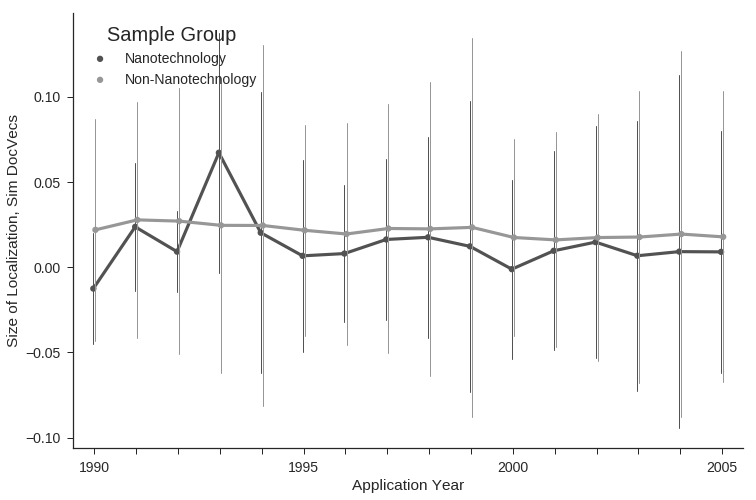

In [9]:
k = "Nanotechnology"
dm = "sim_docvecs"
# c = "msa_{0}".format(dm)
c = "{0}_diff".format(dm)
a = tp_samp_msa[[c, yr]].copy()
a["samp"] = k
b = tp_nonsamp_msa[[c, yr]].copy()
b["samp"] = "Non-{0}".format(k)
df = a.append(b, ignore_index=True)

x1 = "tp_appyear"
y1 = c
hue1 = "samp"
order1 = None
conf_int1 = "sd"
df[x1] = df[x1].astype(int)
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])

# Get every 5 years
plt.setp(g3.get_xticklabels(), visible=False)
plt.setp(g3.get_xticklabels()[::5], visible=True)
plt.savefig(savepath+"4b-NanoLocalSim.png")
plt.show()
del(fig, ax)